#**Task 2: Clustering**



#**Clustering de Productos**
### **Objetivo**
*   Agrupar 3049 ítems en distintos grupos basados en su comportamiento de ventas con el fin de evaluar el performance de diferentes campañas de marketing.
*   ¿Cuántos grupos consideramos?

#Librerias y ficheros

In [1]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#CWD = os.getcwd()
#PATH_DATA = os.path.join(CWD, "data")

#Importamos fichero

In [4]:
df = pd.read_csv("/content/drive/MyDrive/DSMarket/DatosAgrupadosEnSemanas.csv.gz")
df.head()

,id,item,category,department,store,store_code,region,año,semana,trimestre,event,ventas,yearweek,sell_price
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,12.74
1,ACCESORIES_1_002_BOS_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,5.28
2,ACCESORIES_1_003_BOS_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,3.95
3,ACCESORIES_1_004_BOS_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,3,201104,5.77
4,ACCESORIES_1_005_BOS_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,3.63


In [5]:
item_unique = df['item'].nunique()
print(f"Tenemos un total de {item_unique} items únicos en el dataset.")

Tenemos un total de 3049 items únicos en el dataset.




---



#Feature Engineering

##Variables relacionadas a tiempo
Creacion de variables relacionadas a fechas con la finalidad de facilitar el análisis de datos a nivel trimestral, como ventas, ingresos, o cualquier otra métrica temporal.

In [6]:
#Convertimos la columna yearweek (año y semana del año) en un formato de fecha completa.
df['date'] = pd.to_datetime(df['yearweek'].astype(str) + '0', format='%Y%W%w')

In [7]:
#Extraemos el número de mes de la columna date recién creada.
df['month'] = df['date'].dt.month

In [8]:
#Extraemos el trimestre del año al que pertenece cada fecha.
df['quarter'] = df['date'].dt.to_period('Q')

In [9]:
#Creamos una variable binaria para indicar si hubo un evento o no en una semana determinada.
df['is_event'] = np.where(df['event'] == 'Sin_Evento', 0, 1)

### Selección de períodos a analizar
Nuestro dataset cuenta con información desde 2011-01-30 hasta 2016-04-24. Es decir, faltan datos del primer mes del 2011 y de gran parte de 2016.

In [10]:
df['date'].min()

Timestamp('2011-01-30 00:00:00')

In [11]:
df['date'].max()

Timestamp('2016-04-24 00:00:00')

Filtramos datos para solo utilizar 2011 hasta 2015 dado que la ausencia de datos en el año 2016 podría afectar negativamente la calidad del modelo del clustering generando una inconsistencia temporal, sesgando los resultados.

In [12]:
df_filtered = df[(df['date'].dt.year >= 2011) & (df['date'].dt.year <= 2015)].copy()

##Variables relacionadas a ventas

### Ventas totales por item
Periodo 2011-2015.

In [13]:
df_total_sales = df_filtered.groupby('item')['ventas'].sum().reset_index()
df_total_sales.columns = ['item', 'total_sales']
df_total_sales

,item,total_sales
0,ACCESORIES_1_001,3421
1,ACCESORIES_1_002,4727
2,ACCESORIES_1_003,1110
3,ACCESORIES_1_004,37022
4,ACCESORIES_1_005,13315
...,...,...
3044,SUPERMARKET_3_823,14119
3045,SUPERMARKET_3_824,8179
3046,SUPERMARKET_3_825,12346
3047,SUPERMARKET_3_826,10642


###Ventas totales por región para cada ítem

In [14]:
df_ventas_region = df_filtered.groupby(['item', 'region'])['ventas'].sum().reset_index()
df_ventas_region = df_ventas_region.pivot(index='item', columns='region', values='ventas')
df_ventas_region.columns = ['ventas_Boston', 'ventas_New York', 'ventas_Philadelphia']
df_ventas_region.reset_index(inplace=True)
df_ventas_region

,item,ventas_Boston,ventas_New York,ventas_Philadelphia
0,ACCESORIES_1_001,891,2111,419
1,ACCESORIES_1_002,854,1522,2351
2,ACCESORIES_1_003,317,534,259
3,ACCESORIES_1_004,9401,21312,6309
4,ACCESORIES_1_005,3907,6672,2736
...,...,...,...,...
3044,SUPERMARKET_3_823,2129,9336,2654
3045,SUPERMARKET_3_824,1738,4372,2069
3046,SUPERMARKET_3_825,3449,5708,3189
3047,SUPERMARKET_3_826,2626,5145,2871


### Ratio de ventas regionales para cada ítem

In [15]:
# Combina las características de ventas regionales calculando la proporción de ventas en cada región respecto a las ventas totales.
ratio_ventas_Boston = df_ventas_region['ventas_Boston'] / df_total_sales['total_sales']
df_total_sales['ratio_ventas_Boston'] = ratio_ventas_Boston

In [16]:
ratio_ventas_Nueva_York = df_ventas_region['ventas_New York'] / df_total_sales['total_sales']
df_total_sales['ratio_ventas_Nueva_York'] = ratio_ventas_Nueva_York

In [17]:
ratio_ventas_Filadelfia = df_ventas_region['ventas_Philadelphia'] / df_total_sales['total_sales']
df_total_sales['ratio_ventas_Filadelfia'] = ratio_ventas_Filadelfia

In [18]:
df_total_sales

,item,total_sales,ratio_ventas_Boston,ratio_ventas_Nueva_York,ratio_ventas_Filadelfia
0,ACCESORIES_1_001,3421,0.260450,0.617071,0.122479
1,ACCESORIES_1_002,4727,0.180664,0.321980,0.497356
2,ACCESORIES_1_003,1110,0.285586,0.481081,0.233333
3,ACCESORIES_1_004,37022,0.253930,0.575658,0.170412
4,ACCESORIES_1_005,13315,0.293428,0.501089,0.205483
...,...,...,...,...,...
3044,SUPERMARKET_3_823,14119,0.150790,0.661237,0.187974
3045,SUPERMARKET_3_824,8179,0.212495,0.534540,0.252965
3046,SUPERMARKET_3_825,12346,0.279362,0.462336,0.258302
3047,SUPERMARKET_3_826,10642,0.246758,0.483462,0.269780


### Ratio de las ventas para cada ítem por trimestre respecto a las ventas totales

In [19]:
#Agrupamos las ventas por cada ítem y trimestre para sumar las ventas de cada ítem en cada trimestre.
df_sales_quarter = df_filtered.groupby(['item', 'trimestre'])['ventas'].sum().reset_index()

#Usamos pivot para reorganizar los datos de tal manera que cada ítem tenga sus ventas distribuidas en columnas por trimestre.
df_sales_quarter = df_sales_quarter.pivot(index='item', columns='trimestre', values='ventas')
df_sales_quarter.columns = ['ventas_T1', 'ventas_T2', 'ventas_T3', 'ventas_T4']

# Creamos una nueva columna que sume las ventas de todos los trimestres para obtener las ventas totales de cada ítem.
df_sales_quarter['total_sales'] = df_sales_quarter[['ventas_T1', 'ventas_T2', 'ventas_T3', 'ventas_T4']].sum(axis=1)

#Para cada trimestre, se calcula el porcentaje de las ventas totales que ocurrió en ese trimestre.
df_sales_quarter['ventas_T1_ratio'] = df_sales_quarter['ventas_T1'] / df_sales_quarter['total_sales']
df_sales_quarter['ventas_T2_ratio'] = df_sales_quarter['ventas_T2'] / df_sales_quarter['total_sales']
df_sales_quarter['ventas_T3_ratio'] = df_sales_quarter['ventas_T3'] / df_sales_quarter['total_sales']
df_sales_quarter['ventas_T4_ratio'] = df_sales_quarter['ventas_T4'] / df_sales_quarter['total_sales']

#Rellenamos los valores faltantes (NaN) con ceros, en caso de que un ítem no haya tenido ventas en uno o más trimestres.
df_sales_quarter.fillna(0, inplace=True)

#Restablecemos el índice.
df_sales_quarter.reset_index(inplace=True)
df_sales_quarter.drop(columns=['total_sales', 'ventas_T1', 'ventas_T2', 'ventas_T3', 'ventas_T4'], inplace=True)
df_sales_quarter

,item,ventas_T1_ratio,ventas_T2_ratio,ventas_T3_ratio,ventas_T4_ratio
0,ACCESORIES_1_001,0.194388,0.192341,0.277989,0.335282
1,ACCESORIES_1_002,0.170933,0.193780,0.273535,0.361752
2,ACCESORIES_1_003,0.196396,0.252252,0.286486,0.264865
3,ACCESORIES_1_004,0.244152,0.261898,0.241424,0.252526
4,ACCESORIES_1_005,0.189110,0.204807,0.278783,0.327300
...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.246476,0.202847,0.271903,0.278773
3045,SUPERMARKET_3_824,0.232425,0.312752,0.264213,0.190610
3046,SUPERMARKET_3_825,0.266483,0.239349,0.284789,0.209380
3047,SUPERMARKET_3_826,0.173558,0.308119,0.279177,0.239147


### Volatilidad de Ventas por Ítem

Capturar cómo de "estables" o "inestables" son las ventas de un producto. Los ítems con alta volatilidad podrían tener ventas más erráticas, lo que puede deberse a factores externos como promociones o eventos.

In [20]:
df_sales_volatility = df_filtered.groupby('item')['ventas'].std().reset_index()
df_sales_volatility.columns = ['item', 'sales_volatility']
df_sales_volatility

,item,sales_volatility
0,ACCESORIES_1_001,2.059285
1,ACCESORIES_1_002,2.143449
2,ACCESORIES_1_003,1.083329
3,ACCESORIES_1_004,12.881850
4,ACCESORIES_1_005,5.091120
...,...,...
3044,SUPERMARKET_3_823,9.372319
3045,SUPERMARKET_3_824,3.557486
3046,SUPERMARKET_3_825,5.460072
3047,SUPERMARKET_3_826,5.642245


##Variables relacionadas a precio

### Precio Promedio por Ítem

El precio promedio es un indicador clave que nos permitirá identificar qué productos tienden a ser más baratos o caros, y cómo podría relacionarse su precio con las ventas.

In [21]:
df_avg_price = df_filtered.groupby('item')['sell_price'].mean().reset_index()
df_avg_price.columns = ['item', 'avg_price']
df_avg_price

,item,avg_price
0,ACCESORIES_1_001,11.500474
1,ACCESORIES_1_002,5.275658
2,ACCESORIES_1_003,3.947985
3,ACCESORIES_1_004,5.962309
4,ACCESORIES_1_005,3.841816
...,...,...
3044,SUPERMARKET_3_823,3.346143
3045,SUPERMARKET_3_824,3.032904
3046,SUPERMARKET_3_825,4.946857
3047,SUPERMARKET_3_826,1.539750


### Característica de Precio Relativo

Creamos una nueva característica llamada "precio relativo" mediante la comparacion del precio promedio de cada artículo con el precio promedio de todos los artículos dentro de la misma categoría o región.


Normaliza el precio de cada artículo comparándolo con el precio promedio de los artículos de su misma categoría. Esto ayuda a entender cómo se posiciona el precio de un artículo en relación con otros similares.

Nota: Para crear la característica de "precio relativo", necesitas tener una columna de "categoría" o "región" en tus datos que agrupe los artículos en diferentes categorías. Si no tienes esta columna, considera usar las columnas existentes que tengan sentido en tu contexto.

In [22]:
#Calculamos el precio promedio de cada categoría y asigna ese valor a cada ítem dentro de la categoría correspondiente.
precio_promedio_categoria = df_filtered.groupby('category')['sell_price'].transform('mean')

# Creamos una nueva característica de precio relativo.
df_avg_price['precio_relativo'] = df_avg_price['avg_price'] / precio_promedio_categoria

df_avg_price

,item,avg_price,precio_relativo
0,ACCESORIES_1_001,11.500474,1.555689
1,ACCESORIES_1_002,5.275658,0.713647
2,ACCESORIES_1_003,3.947985,0.534051
3,ACCESORIES_1_004,5.962309,0.806532
4,ACCESORIES_1_005,3.841816,0.519689
...,...,...,...
3044,SUPERMARKET_3_823,3.346143,0.849938
3045,SUPERMARKET_3_824,3.032904,0.770374
3046,SUPERMARKET_3_825,4.946857,1.256528
3047,SUPERMARKET_3_826,1.539750,0.391105


### Sensibilidad al precio por Ítem

Crucial para entender cómo los cambios en el precio afectan las ventas de un ítem. Productos con alta sensibilidad podrían requerir estrategias de precios más ajustadas para maximizar sus ventas.

In [23]:
df_price_sensitivity = df_filtered.groupby('item').apply(lambda x: x['sell_price'].corr(x['ventas'])).reset_index()
df_price_sensitivity.columns = ['item', 'price_sensitivity']
df_price_sensitivity.fillna(0, inplace=True)
df_price_sensitivity

,item,price_sensitivity
0,ACCESORIES_1_001,-4.027565e-01
1,ACCESORIES_1_002,2.745416e-02
2,ACCESORIES_1_003,-2.105745e-02
3,ACCESORIES_1_004,1.277156e-01
4,ACCESORIES_1_005,-1.351870e-01
...,...,...
3044,SUPERMARKET_3_823,-1.109782e-01
3045,SUPERMARKET_3_824,8.019106e-02
3046,SUPERMARKET_3_825,-2.496320e-01
3047,SUPERMARKET_3_826,1.160073e-02


### Volatilidad Estacional de Precios

Agrupamos el DataFrame por la columna category y se calcula la media de los precios de venta (sell_price). Luego, el método transform('mean') asegura que este valor promedio se asigne a cada ítem dentro de su categoría.

Seguidamente, tomamos el precio promedio del ítem (avg_price) y se divide entre el precio promedio de la categoría a la que pertenece. Este ratio indica si un ítem es más caro o más barato en relación con otros ítems de su misma categoría.

De esta manera, medimos cómo fluctúa el precio de un producto durante diferentes estaciones o períodos de tiempo (trimestres en este caso).

In [24]:
#Calculamos la desviación estándar del precio para cada ítem dentro de cada trimestre.
df_seasonal_price_volatility = df_filtered.groupby(['item', 'trimestre'])['sell_price'].std().reset_index()

#Renombramos coluumnas.
df_seasonal_price_volatility = df_seasonal_price_volatility.pivot(index='item', columns='trimestre', values='sell_price')
df_seasonal_price_volatility.columns = ['std_price_T1', 'std_price_T2', 'std_price_T3', 'std_price_T4']
df_seasonal_price_volatility.reset_index(inplace=True)
df_seasonal_price_volatility

,item,std_price_T1,std_price_T2,std_price_T3,std_price_T4
0,ACCESORIES_1_001,0.763148,0.771823,0.747117,0.692890
1,ACCESORIES_1_002,0.177719,0.000000,0.050269,0.100472
2,ACCESORIES_1_003,0.105903,0.234120,0.181368,0.000000
3,ACCESORIES_1_004,0.292689,0.279122,0.278106,0.280135
4,ACCESORIES_1_005,0.255182,0.171183,0.174750,0.272204
...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.203844,0.213758,0.205085,0.246883
3045,SUPERMARKET_3_824,0.237880,0.247006,0.264461,0.263062
3046,SUPERMARKET_3_825,0.232477,0.264246,0.212393,0.257086
3047,SUPERMARKET_3_826,0.013336,0.012944,0.000000,0.000000


##Variables relacionadas a crecimiento de ventas

### Crecimiento anual de ventas para cada ítem
Aplicado solo para los años comprendidos entre 2011 y 2015.

In [25]:
#Definimos una función que tiene como objetivo calcular el crecimiento anual de ventas de 2011 a 2015 para cada ítem.
def calculate_annual_sales_growth(df):

  # Filtramos datos para obtener datos soolo del año 2011 hasta 2015.
  df_filtered = df[(df['año'] >= 2011) & (df['año'] <= 2015)]

  #Agrupamos por ítem y año, añadiendo las ventas.
  sales_by_item_year = df_filtered.groupby(['item', 'año'])['ventas'].sum().reset_index()

  #Pivotamos la tabla para tener los años como columnas.
  sales_pivot = sales_by_item_year.pivot(index='item', columns='año', values='ventas')

  #Calculamos la tasa de crecimiento.
  sales_pivot['growth_2012'] = ((sales_pivot[2012] - sales_pivot[2011]) / sales_pivot[2011]) * 100
  sales_pivot['growth_2013'] = ((sales_pivot[2013] - sales_pivot[2012]) / sales_pivot[2012]) * 100
  sales_pivot['growth_2014'] = ((sales_pivot[2014] - sales_pivot[2013]) / sales_pivot[2013]) * 100
  sales_pivot['growth_2015'] = ((sales_pivot[2015] - sales_pivot[2014]) / sales_pivot[2014]) * 100

  return sales_pivot[['growth_2012', 'growth_2013', 'growth_2014', 'growth_2015']]

#Apliacamos la función al dataset df.
df_annual_sales_growth = calculate_annual_sales_growth(df)

df_annual_sales_growth

año,growth_2012,growth_2013,growth_2014,growth_2015
item,,,,
ACCESORIES_1_001,NaN,inf,118.493151,27.272727
ACCESORIES_1_002,40.508021,-1.332065,-8.100289,4.512067
ACCESORIES_1_003,NaN,NaN,inf,130.113636
ACCESORIES_1_004,15.679384,20.497613,4.717887,-15.969277
ACCESORIES_1_005,-3.617479,-5.016722,-11.893584,40.719361
...,...,...,...,...
SUPERMARKET_3_823,-55.242246,-12.313860,53.037231,103.627828
SUPERMARKET_3_824,-1.339093,-30.429072,-7.803650,-64.095563
SUPERMARKET_3_825,-54.222074,49.455338,47.035957,-2.941176


In [26]:
df_annual_sales_growth.replace([np.inf, -np.inf], np.nan, inplace=True)
df_annual_sales_growth.fillna(0, inplace=True)
df_annual_sales_growth

año,growth_2012,growth_2013,growth_2014,growth_2015
item,,,,
ACCESORIES_1_001,0.000000,0.000000,118.493151,27.272727
ACCESORIES_1_002,40.508021,-1.332065,-8.100289,4.512067
ACCESORIES_1_003,0.000000,0.000000,0.000000,130.113636
ACCESORIES_1_004,15.679384,20.497613,4.717887,-15.969277
ACCESORIES_1_005,-3.617479,-5.016722,-11.893584,40.719361
...,...,...,...,...
SUPERMARKET_3_823,-55.242246,-12.313860,53.037231,103.627828
SUPERMARKET_3_824,-1.339093,-30.429072,-7.803650,-64.095563
SUPERMARKET_3_825,-54.222074,49.455338,47.035957,-2.941176


In [27]:
df_annual_sales_growth['average_growth'] = df_annual_sales_growth.mean(axis=1)
df_annual_sales_growth

año,growth_2012,growth_2013,growth_2014,growth_2015,average_growth
item,,,,,
ACCESORIES_1_001,0.000000,0.000000,118.493151,27.272727,36.441469
ACCESORIES_1_002,40.508021,-1.332065,-8.100289,4.512067,8.896934
ACCESORIES_1_003,0.000000,0.000000,0.000000,130.113636,32.528409
ACCESORIES_1_004,15.679384,20.497613,4.717887,-15.969277,6.231402
ACCESORIES_1_005,-3.617479,-5.016722,-11.893584,40.719361,5.047894
...,...,...,...,...,...
SUPERMARKET_3_823,-55.242246,-12.313860,53.037231,103.627828,22.277238
SUPERMARKET_3_824,-1.339093,-30.429072,-7.803650,-64.095563,-25.916844
SUPERMARKET_3_825,-54.222074,49.455338,47.035957,-2.941176,9.832011


##Variables relacionadas a eventos


### Ratio de Impacto de Eventos por Trimestre

In [28]:
#Calculamos las ventas totales durante eventos por ítem y trimestre.
event_sales = df_filtered[df_filtered['is_event'] == 1].groupby(['item', 'trimestre'])['ventas'].sum().reset_index()
event_sales.rename(columns={'ventas': 'event_sales'}, inplace=True)

#Calculamos las ventas totales por ítem y trimestre.
total_sales_per_quarter = df_filtered.groupby(['item', 'trimestre'])['ventas'].sum().reset_index()
total_sales_per_quarter.rename(columns={'ventas': 'total_sales_per_quarter'}, inplace=True)

#Unión de las ventas totales con las ventas durante eventos.
df_event_impact = pd.merge(event_sales, total_sales_per_quarter, on=['item', 'trimestre'], how='left')

#Calculamos el ratio de impacto de eventos.
df_event_impact['event_impact_ratio_per_quarter'] = df_event_impact['event_sales'] / df_event_impact['total_sales_per_quarter']

#Reorganizamos el DataFrame con trimestres como columnas.
df_event_impact = df_event_impact.pivot(index='item', columns='trimestre', values='event_impact_ratio_per_quarter')
df_event_impact.rename(columns={1: 'event_impact_ratio_T1', 2: 'event_impact_ratio_T2', 3: 'event_impact_ratio_T3', 4: 'event_impact_ratio_T4'}, inplace=True)

df_event_impact.fillna(0, inplace=True)
df_event_impact.reset_index(inplace=True)
df_event_impact

trimestre,item,event_impact_ratio_T1,event_impact_ratio_T2,event_impact_ratio_T3,event_impact_ratio_T4
0,ACCESORIES_1_001,0.114286,0.167173,0.000000,0.068003
1,ACCESORIES_1_002,0.137376,0.082969,0.056458,0.057310
2,ACCESORIES_1_003,0.091743,0.135714,0.000000,0.068027
3,ACCESORIES_1_004,0.145149,0.072917,0.028977,0.074446
4,ACCESORIES_1_005,0.163225,0.057939,0.046606,0.068380
...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.100575,0.061453,0.035165,0.060213
3045,SUPERMARKET_3_824,0.139400,0.050430,0.059695,0.051315
3046,SUPERMARKET_3_825,0.105167,0.089340,0.046075,0.058801
3047,SUPERMARKET_3_826,0.129399,0.100335,0.033322,0.058546


##Merged df: df_features
Combinamos todos los dataframes en uno solo.

In [29]:
df_features = df_total_sales \
    .merge(df_sales_quarter, on='item', how='left') \
    .merge(df_sales_volatility, on='item', how='left') \
    .merge(df_avg_price, on='item', how='left') \
    .merge(df_price_sensitivity, on='item', how='left') \
    .merge(df_seasonal_price_volatility, on='item', how='left') \
    .merge(df_annual_sales_growth, on='item', how='left') \
    .merge(df_event_impact, on='item', how='left')

df_features.set_index('item', inplace=True)

df_features

,total_sales,ratio_ventas_Boston,ratio_ventas_Nueva_York,ratio_ventas_Filadelfia,ventas_T1_ratio,ventas_T2_ratio,ventas_T3_ratio,ventas_T4_ratio,sales_volatility,avg_price,...,std_price_T4,growth_2012,growth_2013,growth_2014,growth_2015,average_growth,event_impact_ratio_T1,event_impact_ratio_T2,event_impact_ratio_T3,event_impact_ratio_T4
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,3421,0.260450,0.617071,0.122479,0.194388,0.192341,0.277989,0.335282,2.059285,11.500474,...,0.692890,0.000000,0.000000,118.493151,27.272727,36.441469,0.114286,0.167173,0.000000,0.068003
ACCESORIES_1_002,4727,0.180664,0.321980,0.497356,0.170933,0.193780,0.273535,0.361752,2.143449,5.275658,...,0.100472,40.508021,-1.332065,-8.100289,4.512067,8.896934,0.137376,0.082969,0.056458,0.057310
ACCESORIES_1_003,1110,0.285586,0.481081,0.233333,0.196396,0.252252,0.286486,0.264865,1.083329,3.947985,...,0.000000,0.000000,0.000000,0.000000,130.113636,32.528409,0.091743,0.135714,0.000000,0.068027
ACCESORIES_1_004,37022,0.253930,0.575658,0.170412,0.244152,0.261898,0.241424,0.252526,12.881850,5.962309,...,0.280135,15.679384,20.497613,4.717887,-15.969277,6.231402,0.145149,0.072917,0.028977,0.074446
ACCESORIES_1_005,13315,0.293428,0.501089,0.205483,0.189110,0.204807,0.278783,0.327300,5.091120,3.841816,...,0.272204,-3.617479,-5.016722,-11.893584,40.719361,5.047894,0.163225,0.057939,0.046606,0.068380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,14119,0.150790,0.661237,0.187974,0.246476,0.202847,0.271903,0.278773,9.372319,3.346143,...,0.246883,-55.242246,-12.313860,53.037231,103.627828,22.277238,0.100575,0.061453,0.035165,0.060213
SUPERMARKET_3_824,8179,0.212495,0.534540,0.252965,0.232425,0.312752,0.264213,0.190610,3.557486,3.032904,...,0.263062,-1.339093,-30.429072,-7.803650,-64.095563,-25.916844,0.139400,0.050430,0.059695,0.051315
SUPERMARKET_3_825,12346,0.279362,0.462336,0.258302,0.266483,0.239349,0.284789,0.209380,5.460072,4.946857,...,0.257086,-54.222074,49.455338,47.035957,-2.941176,9.832011,0.105167,0.089340,0.046075,0.058801


In [30]:
#Comprobamos que no hayan nulos.
df_features.isnull().sum()

,0
total_sales,0
ratio_ventas_Boston,0
ratio_ventas_Nueva_York,0
ratio_ventas_Filadelfia,0
ventas_T1_ratio,0
ventas_T2_ratio,0
ventas_T3_ratio,0
ventas_T4_ratio,0
sales_volatility,0
avg_price,0




---



#ITERACIÓN 1

## IT1. Evaluate Features

### Feature Variance
**Interpret the Results:** If you find features with near-zero variance, consider removing them as they are unlikely to help in differentiating clusters

In [31]:
feature_variances = df_features.var()

print("Feature Variances:\n", feature_variances)

Feature Variances:
 total_sales                1.727335e+09
ratio_ventas_Boston        9.135408e-03
ratio_ventas_Nueva_York    1.281527e-02
ratio_ventas_Filadelfia    1.007430e-02
ventas_T1_ratio            2.500128e-03
ventas_T2_ratio            2.362395e-03
ventas_T3_ratio            2.604914e-03
ventas_T4_ratio            3.951024e-03
sales_volatility           2.235551e+02
avg_price                  2.054069e+01
precio_relativo            4.936928e-01
price_sensitivity          2.445322e-02
std_price_T1               9.393868e-02
std_price_T2               9.447836e-02
std_price_T3               7.636687e-02
std_price_T4               1.026768e-01
growth_2012                3.420251e+08
growth_2013                1.582832e+07
growth_2014                2.562686e+07
growth_2015                2.513637e+07
average_growth             2.545284e+07
event_impact_ratio_T1      1.190489e-03
event_impact_ratio_T2      1.302401e-03
event_impact_ratio_T3      4.515192e-04
event_impact_ratio_T

### Feature Correlation

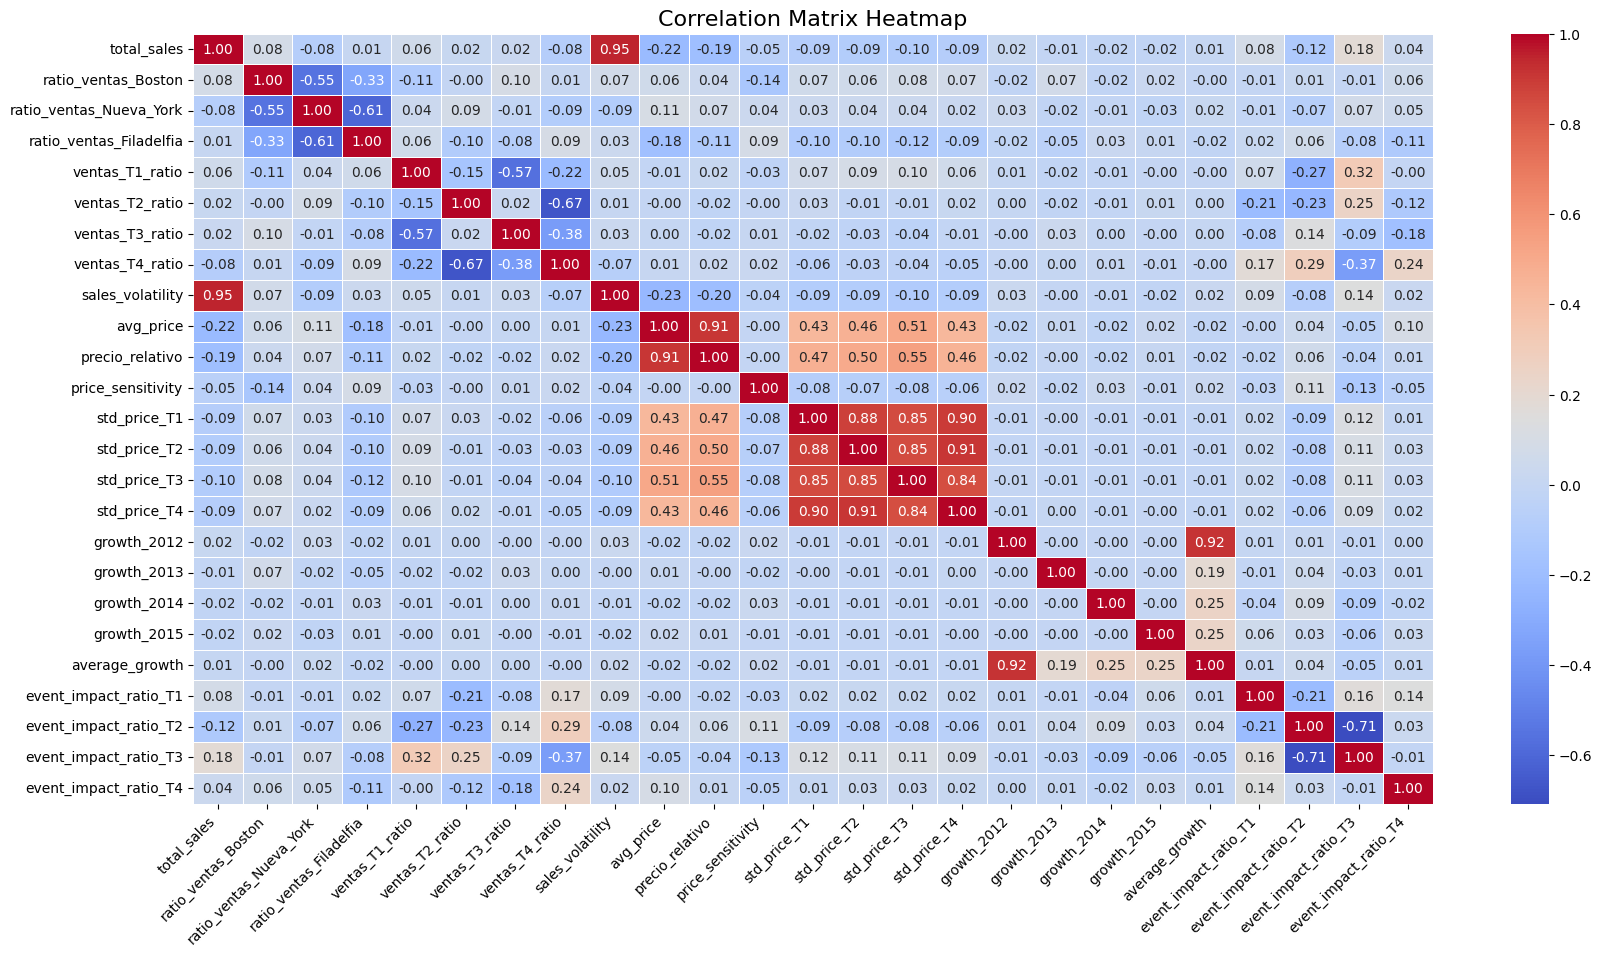

In [32]:
correlation_matrix = df_features.corr()

plt.figure(figsize=(20, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title("Correlation Matrix Heatmap", fontsize=16)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

In [33]:
correlation_matrix = df_features.corr()

print("Feature Correlation Matrix:\n", correlation_matrix)

Feature Correlation Matrix:
                          total_sales  ratio_ventas_Boston  \
total_sales                 1.000000             0.081960   
ratio_ventas_Boston         0.081960             1.000000   
ratio_ventas_Nueva_York    -0.075576            -0.548815   
ratio_ventas_Filadelfia     0.007192            -0.333274   
ventas_T1_ratio             0.062552            -0.106311   
ventas_T2_ratio             0.018448            -0.000775   
ventas_T3_ratio             0.022384             0.096954   
ventas_T4_ratio            -0.082198             0.006443   
sales_volatility            0.950430             0.071549   
avg_price                  -0.217533             0.063940   
precio_relativo            -0.189315             0.036619   
price_sensitivity          -0.054570            -0.137527   
std_price_T1               -0.086564             0.065149   
std_price_T2               -0.089663             0.059922   
std_price_T3               -0.100142             0.07560



---



## IT1. Estandarizacion de datos

In [34]:
from sklearn.preprocessing import StandardScaler

#Seleccionamos variables para nuestra primera iteracion.
selected_features = df_features[[
    'total_sales',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    'avg_price',
    'price_sensitivity',
    #'ventas_T1_ratio',
    #'ventas_T2_ratio',
    #'ventas_T3_ratio',
    #'ventas_T4_ratio',
    #'event_impact_ratio_T1',
    #'event_impact_ratio_T2',
    #'event_impact_ratio_T3',
    #'event_impact_ratio_T4',
    'growth_2012',
    'growth_2013',
    'growth_2014',
    'growth_2015',
    'average_growth'
    ]]

selected_features = selected_features.fillna(0)

#Normalizamos datos.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

## IT1. Análisis de Componentes Principales (PCA)

In [35]:
from sklearn.decomposition import PCA

n_components=6

pca = PCA(n_components)
A = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)

Varianza explicada por cada componente: [0.18201143 0.15739942 0.13324545 0.10664382 0.09146104 0.08998112]


In [36]:
cumulative_variance = explained_variance.cumsum()
exp_var_ratio_sum = sum(explained_variance)

print(f"Con {n_components} componentes, explicamos el {exp_var_ratio_sum*100:.2f}% de la varianza original.")

Con 6 componentes, explicamos el 76.07% de la varianza original.


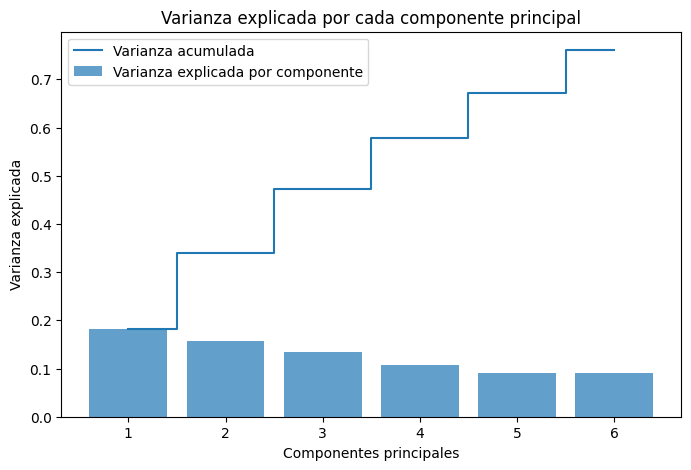

In [37]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, align='center', label='Varianza explicada por componente')
plt.step(range(1, n_components + 1), cumulative_variance, where='mid', label='Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada')
plt.title('Varianza explicada por cada componente principal')
plt.legend(loc='best')
plt.show()

## IT1. Elbow Curve

In [38]:
pca_data_4 = A.iloc[:, :4]


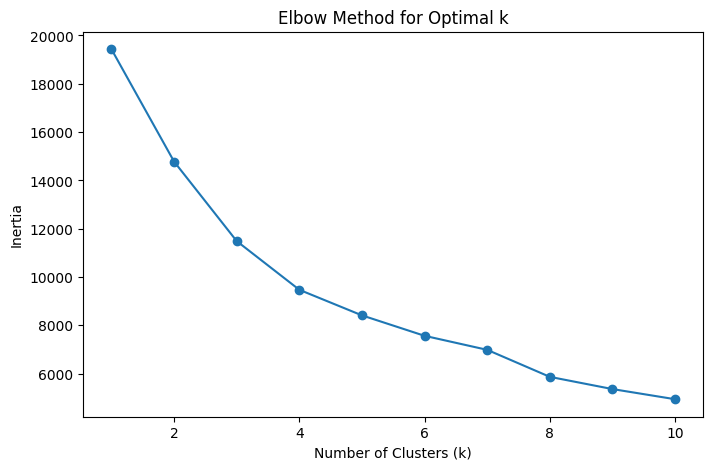

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data_4)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [40]:
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(pca_data_4)

df_features['cluster_IT1'] = cluster_labels

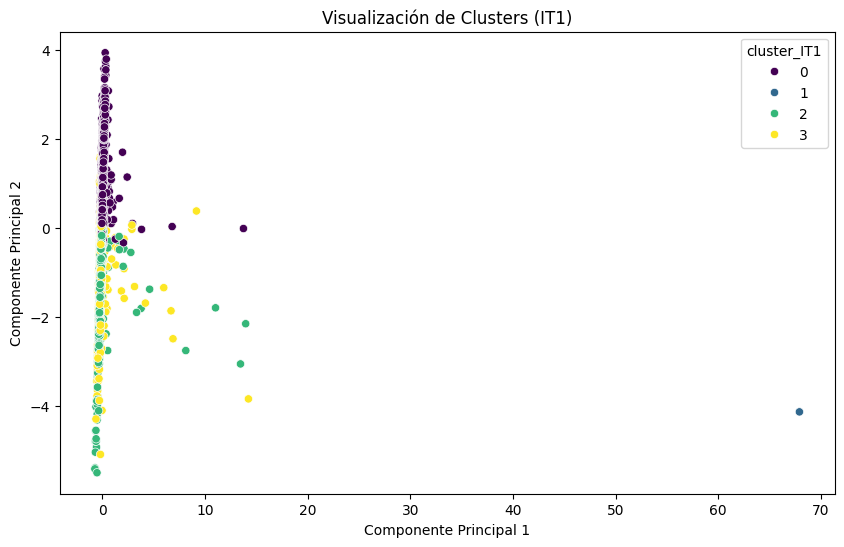

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=A.iloc[:, 0], y=A.iloc[:, 1], hue=df_features['cluster_IT1'], palette='viridis') # Use .iloc to slice the DataFrame
plt.title('Visualización de Clusters (IT1)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

## IT1. Coeficiente de Silueta

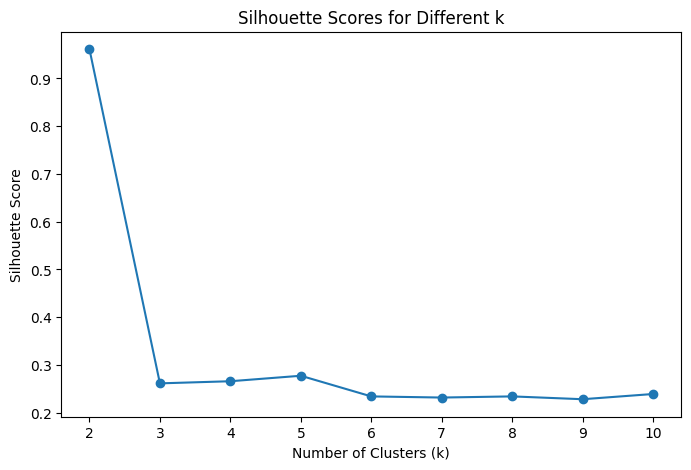

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_data_4)
    silhouette_avg = silhouette_score(pca_data_4, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


## IT1. Asignacion de labels

In [43]:
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(pca_data_4)

df_features['cluster_IT1'] = cluster_labels

## IT1. Fichas

In [44]:
features_df = df_features[[
    'total_sales',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    'avg_price',
    'price_sensitivity',
    #'ventas_T1_ratio',
    #'ventas_T2_ratio',
    #'ventas_T3_ratio',
    #'ventas_T4_ratio',
    #'event_impact_ratio_T1',
    #'event_impact_ratio_T2',
    #'event_impact_ratio_T3',
    #'event_impact_ratio_T4',
    'growth_2012',
    'growth_2013',
    'growth_2014',
    'growth_2015',
    'average_growth',
    'cluster_IT1'
    ]].groupby("cluster_IT1").describe().T

features_df.style.background_gradient(cmap = 'Blues', axis = 1)



---



#ITERACIÓN 2: Enfoque en ventas totales y patrones generales
Propósito: comprender las principales tendencias de ventas, las contribuciones regionales y la distribución trimestral mientras se minimiza el ruido de variables de menor impacto.

In [45]:
df_features = df_total_sales \
    .merge(df_sales_quarter, on='item', how='left') \
    .merge(df_sales_volatility, on='item', how='left') \
    .merge(df_avg_price, on='item', how='left') \
    .merge(df_price_sensitivity, on='item', how='left') \
    .merge(df_seasonal_price_volatility, on='item', how='left') \
    .merge(df_annual_sales_growth, on='item', how='left') \
    .merge(df_event_impact, on='item', how='left')

df_features.set_index('item', inplace=True)

In [46]:
df_features = df_features[[
    'total_sales',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    'ventas_T1_ratio',
    'ventas_T2_ratio',
    'ventas_T3_ratio',
    'ventas_T4_ratio',
    'std_price_T1',
    'std_price_T2',
    'std_price_T3',
    'std_price_T4',
    'avg_price',
    #'precio_relativo',
    'price_sensitivity',
    'event_impact_ratio_T1',
    'event_impact_ratio_T2',
    'event_impact_ratio_T3',
    'event_impact_ratio_T4',
    #'growth_2012',
    #'growth_2013',
    #'growth_2014',
    #'growth_2015',
    #'average_growth'
    ]]

df_features = df_features.fillna(0)
df_features

,total_sales,ratio_ventas_Boston,ratio_ventas_Nueva_York,ratio_ventas_Filadelfia,ventas_T1_ratio,ventas_T2_ratio,ventas_T3_ratio,ventas_T4_ratio,std_price_T1,std_price_T2,std_price_T3,std_price_T4,avg_price,price_sensitivity,event_impact_ratio_T1,event_impact_ratio_T2,event_impact_ratio_T3,event_impact_ratio_T4
item,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,3421,0.260450,0.617071,0.122479,0.194388,0.192341,0.277989,0.335282,0.763148,0.771823,0.747117,0.692890,11.500474,-4.027565e-01,0.114286,0.167173,0.000000,0.068003
ACCESORIES_1_002,4727,0.180664,0.321980,0.497356,0.170933,0.193780,0.273535,0.361752,0.177719,0.000000,0.050269,0.100472,5.275658,2.745416e-02,0.137376,0.082969,0.056458,0.057310
ACCESORIES_1_003,1110,0.285586,0.481081,0.233333,0.196396,0.252252,0.286486,0.264865,0.105903,0.234120,0.181368,0.000000,3.947985,-2.105745e-02,0.091743,0.135714,0.000000,0.068027
ACCESORIES_1_004,37022,0.253930,0.575658,0.170412,0.244152,0.261898,0.241424,0.252526,0.292689,0.279122,0.278106,0.280135,5.962309,1.277156e-01,0.145149,0.072917,0.028977,0.074446
ACCESORIES_1_005,13315,0.293428,0.501089,0.205483,0.189110,0.204807,0.278783,0.327300,0.255182,0.171183,0.174750,0.272204,3.841816,-1.351870e-01,0.163225,0.057939,0.046606,0.068380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,14119,0.150790,0.661237,0.187974,0.246476,0.202847,0.271903,0.278773,0.203844,0.213758,0.205085,0.246883,3.346143,-1.109782e-01,0.100575,0.061453,0.035165,0.060213
SUPERMARKET_3_824,8179,0.212495,0.534540,0.252965,0.232425,0.312752,0.264213,0.190610,0.237880,0.247006,0.264461,0.263062,3.032904,8.019106e-02,0.139400,0.050430,0.059695,0.051315
SUPERMARKET_3_825,12346,0.279362,0.462336,0.258302,0.266483,0.239349,0.284789,0.209380,0.232477,0.264246,0.212393,0.257086,4.946857,-2.496320e-01,0.105167,0.089340,0.046075,0.058801


## IT2. Feature Variance

In [47]:
feature_variances = df_features.var()

print("Feature Variances:\n", feature_variances)

Feature Variances:
 total_sales                1.727335e+09
ratio_ventas_Boston        9.135408e-03
ratio_ventas_Nueva_York    1.281527e-02
ratio_ventas_Filadelfia    1.007430e-02
ventas_T1_ratio            2.500128e-03
ventas_T2_ratio            2.362395e-03
ventas_T3_ratio            2.604914e-03
ventas_T4_ratio            3.951024e-03
std_price_T1               9.393868e-02
std_price_T2               9.447836e-02
std_price_T3               7.636687e-02
std_price_T4               1.026768e-01
avg_price                  2.054069e+01
price_sensitivity          2.445322e-02
event_impact_ratio_T1      1.190489e-03
event_impact_ratio_T2      1.302401e-03
event_impact_ratio_T3      4.515192e-04
event_impact_ratio_T4      3.126910e-04
dtype: float64


## IT2. Feature Correlation.

In [48]:
correlation_matrix = df_features.corr()

print("Feature Correlation Matrix:\n", correlation_matrix)

Feature Correlation Matrix:
                          total_sales  ratio_ventas_Boston  \
total_sales                 1.000000             0.081960   
ratio_ventas_Boston         0.081960             1.000000   
ratio_ventas_Nueva_York    -0.075576            -0.548815   
ratio_ventas_Filadelfia     0.007192            -0.333274   
ventas_T1_ratio             0.062552            -0.106311   
ventas_T2_ratio             0.018448            -0.000775   
ventas_T3_ratio             0.022384             0.096954   
ventas_T4_ratio            -0.082198             0.006443   
std_price_T1               -0.086564             0.065149   
std_price_T2               -0.089663             0.059922   
std_price_T3               -0.100142             0.075606   
std_price_T4               -0.086983             0.068312   
avg_price                  -0.217533             0.063940   
price_sensitivity          -0.054570            -0.137527   
event_impact_ratio_T1       0.084201            -0.00598

## IT2. Estandarización de datos

In [49]:
from sklearn.preprocessing import StandardScaler

selected_features = df_features[[
    'total_sales',
    'ventas_T1_ratio',
    'ventas_T2_ratio',
    'ventas_T3_ratio',
    'ventas_T4_ratio',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    'avg_price'
    ]]

selected_features = selected_features.fillna(0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)


In [50]:
selected_features

,total_sales,ventas_T1_ratio,ventas_T2_ratio,ventas_T3_ratio,ventas_T4_ratio,ratio_ventas_Boston,ratio_ventas_Nueva_York,ratio_ventas_Filadelfia,avg_price
item,,,,,,,,,
ACCESORIES_1_001,3421,0.194388,0.192341,0.277989,0.335282,0.260450,0.617071,0.122479,11.500474
ACCESORIES_1_002,4727,0.170933,0.193780,0.273535,0.361752,0.180664,0.321980,0.497356,5.275658
ACCESORIES_1_003,1110,0.196396,0.252252,0.286486,0.264865,0.285586,0.481081,0.233333,3.947985
ACCESORIES_1_004,37022,0.244152,0.261898,0.241424,0.252526,0.253930,0.575658,0.170412,5.962309
ACCESORIES_1_005,13315,0.189110,0.204807,0.278783,0.327300,0.293428,0.501089,0.205483,3.841816
...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,14119,0.246476,0.202847,0.271903,0.278773,0.150790,0.661237,0.187974,3.346143
SUPERMARKET_3_824,8179,0.232425,0.312752,0.264213,0.190610,0.212495,0.534540,0.252965,3.032904
SUPERMARKET_3_825,12346,0.266483,0.239349,0.284789,0.209380,0.279362,0.462336,0.258302,4.946857


## IT2. Análisis de Componentes Principales (PCA)

In [51]:
from sklearn.decomposition import PCA

n_components=6

pca = PCA(n_components)
A = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)

Varianza explicada por cada componente: [0.21559436 0.18988632 0.16832645 0.14195601 0.12389146 0.08430792]


In [52]:
cumulative_variance = explained_variance.cumsum()
exp_var_ratio_sum = sum(explained_variance)

print(f"Con {n_components} componentes, explicamos el {exp_var_ratio_sum*100:.2f}% de la varianza original.")

Con 6 componentes, explicamos el 92.40% de la varianza original.


## IT2. KMeans

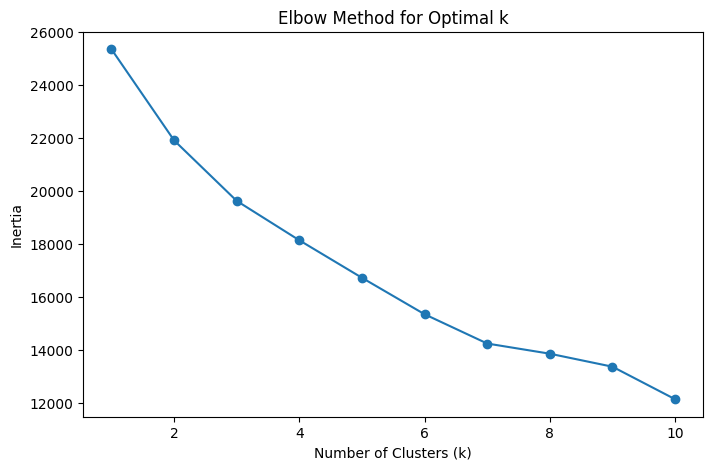

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(A)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [54]:
optimal_k = 8

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(A)

df_features['cluster_IT2'] = cluster_labels

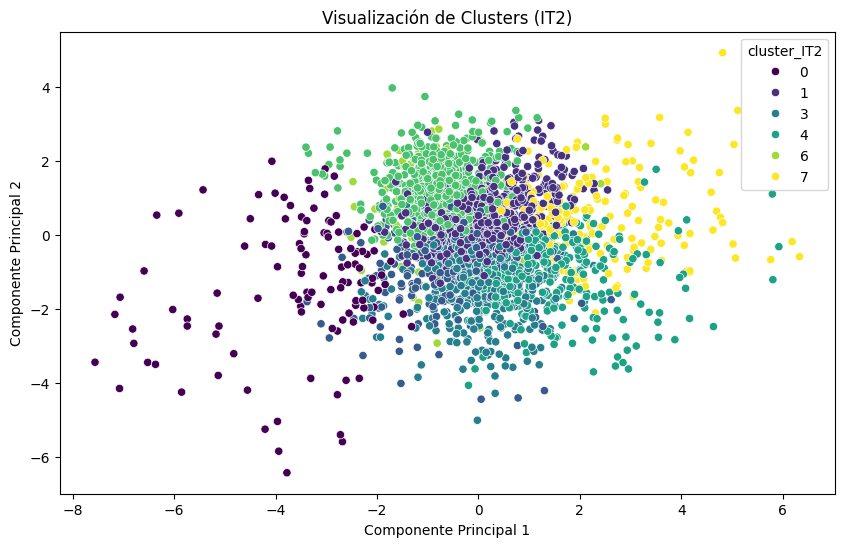

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=A.iloc[:, 0], y=A.iloc[:, 1], hue=df_features['cluster_IT2'], palette='viridis') # Use .iloc to slice the DataFrame
plt.title('Visualización de Clusters (IT2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

## IT2. Fichas

In [56]:
features_df = df_features[[
    'total_sales',
    'ventas_T1_ratio',
    'ventas_T2_ratio',
    'ventas_T3_ratio',
    'ventas_T4_ratio',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    'avg_price',
    'cluster_IT2'
    ]].groupby("cluster_IT2").describe().T

features_df.style.background_gradient(cmap = 'Blues', axis = 1)



---



# ITERACIÓN 3: Enfoque en dinámicas de ventas regionales y estacionales
Propósito: Concéntrese en la dinámica de las ventas en todas las regiones y temporadas, entendiendo qué artículos funcionan mejor en determinadas áreas o períodos.

## IT3. Estandarización de datos

In [57]:
df_features = df_total_sales \
    .merge(df_sales_quarter, on='item', how='left') \
    .merge(df_sales_volatility, on='item', how='left') \
    .merge(df_avg_price, on='item', how='left') \
    .merge(df_price_sensitivity, on='item', how='left') \
    .merge(df_seasonal_price_volatility, on='item', how='left') \
    .merge(df_annual_sales_growth, on='item', how='left') \
    .merge(df_event_impact, on='item', how='left')

df_features.set_index('item', inplace=True)

In [58]:
from sklearn.preprocessing import StandardScaler

selected_features = df_features[[
    'total_sales',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    'ventas_T1_ratio',
    'ventas_T2_ratio',
    'ventas_T3_ratio',
    'ventas_T4_ratio',
    'event_impact_ratio_T1',
    'event_impact_ratio_T2',
    'event_impact_ratio_T3',
    'event_impact_ratio_T4',
    ]]

selected_features = selected_features.fillna(0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

## IT3. Análisis de Componentes Principales (PCA)

In [59]:
from sklearn.decomposition import PCA

n_components=6

pca = PCA(n_components)
A = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)

Varianza explicada por cada componente: [0.20516328 0.16485608 0.13822541 0.11972732 0.09336297 0.07637775]


In [60]:
cumulative_variance = explained_variance.cumsum()
exp_var_ratio_sum = sum(explained_variance)

print(f"Con {n_components} componentes, explicamos el {exp_var_ratio_sum*100:.2f}% de la varianza original.")

Con 6 componentes, explicamos el 79.77% de la varianza original.


## IT3. KMeans

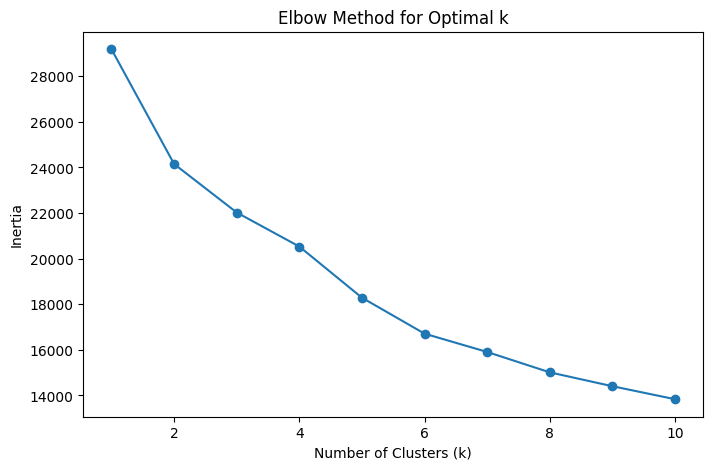

In [61]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(A)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [62]:
from sklearn.cluster import KMeans

optimal_k = 6

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(A)

df_features['cluster_IT3'] = cluster_labels

## IT3. Fichas

In [63]:
features_df = df_features[[
    'total_sales',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    'ventas_T1_ratio',
    'ventas_T2_ratio',
    'ventas_T3_ratio',
    'ventas_T4_ratio',
    'event_impact_ratio_T1',
    'event_impact_ratio_T2',
    'event_impact_ratio_T3',
    'event_impact_ratio_T4',
    'cluster_IT3'
    ]].groupby("cluster_IT3").describe().T

features_df.style.background_gradient(cmap = 'Blues', axis = 1)



---



#ITERACIÓN 4: Enfoque en la sensibilidad de precio y el impacto de eventos
Propósito: comprender la relación entre los cambios de precios, las ventas impulsadas por eventos y la sensibilidad general al precio, lo que ayuda a optimizar las estrategias de precios y promociones.

## IT4. Estandarización de datos

In [64]:
df_features = df_total_sales \
    .merge(df_sales_quarter, on='item', how='left') \
    .merge(df_sales_volatility, on='item', how='left') \
    .merge(df_avg_price, on='item', how='left') \
    .merge(df_price_sensitivity, on='item', how='left') \
    .merge(df_seasonal_price_volatility, on='item', how='left') \
    .merge(df_annual_sales_growth, on='item', how='left') \
    .merge(df_event_impact, on='item', how='left')

df_features.set_index('item', inplace=True)

In [65]:
from sklearn.preprocessing import StandardScaler

selected_features = df_features[[
    'total_sales',
    'avg_price',
    'std_price_T1',
    'std_price_T2',
    'std_price_T3',
    'std_price_T4',
    'price_sensitivity',
    'event_impact_ratio_T1',
    'event_impact_ratio_T2',
    'event_impact_ratio_T3',
    'event_impact_ratio_T4'
    ]]

selected_features = selected_features.fillna(0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

## IT4. Análisis de Componentes Principales (PCA)

In [66]:
from sklearn.decomposition import PCA

n_components=6

pca = PCA(n_components)
A = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)

Varianza explicada por cada componente: [0.35933592 0.17293977 0.10264229 0.08982106 0.08568902 0.07263082]


In [67]:
cumulative_variance = explained_variance.cumsum()
exp_var_ratio_sum = sum(explained_variance)

print(f"Con {n_components} componentes, explicamos el {exp_var_ratio_sum*100:.2f}% de la varianza original.")

Con 6 componentes, explicamos el 88.31% de la varianza original.


## IT4. KMeans

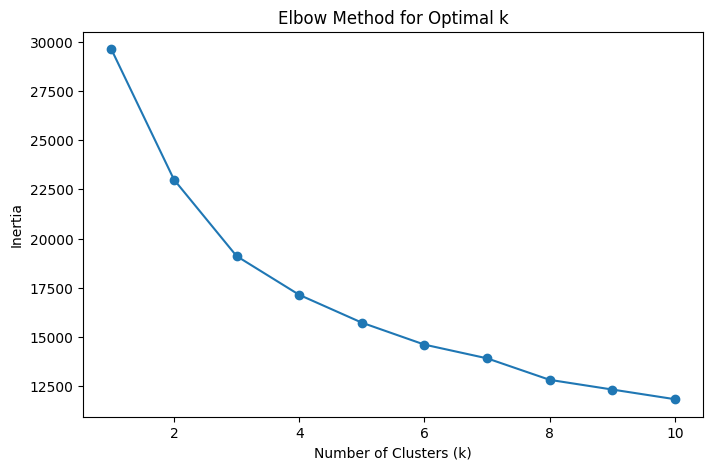

In [68]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(A)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [69]:
from sklearn.cluster import KMeans

optimal_k = 6

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(A)

df_features['cluster_IT4'] = cluster_labels

df_features

,total_sales,ratio_ventas_Boston,ratio_ventas_Nueva_York,ratio_ventas_Filadelfia,ventas_T1_ratio,ventas_T2_ratio,ventas_T3_ratio,ventas_T4_ratio,sales_volatility,avg_price,...,growth_2012,growth_2013,growth_2014,growth_2015,average_growth,event_impact_ratio_T1,event_impact_ratio_T2,event_impact_ratio_T3,event_impact_ratio_T4,cluster_IT4
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,3421,0.260450,0.617071,0.122479,0.194388,0.192341,0.277989,0.335282,2.059285,11.500474,...,0.000000,0.000000,118.493151,27.272727,36.441469,0.114286,0.167173,0.000000,0.068003,0
ACCESORIES_1_002,4727,0.180664,0.321980,0.497356,0.170933,0.193780,0.273535,0.361752,2.143449,5.275658,...,40.508021,-1.332065,-8.100289,4.512067,8.896934,0.137376,0.082969,0.056458,0.057310,2
ACCESORIES_1_003,1110,0.285586,0.481081,0.233333,0.196396,0.252252,0.286486,0.264865,1.083329,3.947985,...,0.000000,0.000000,0.000000,130.113636,32.528409,0.091743,0.135714,0.000000,0.068027,1
ACCESORIES_1_004,37022,0.253930,0.575658,0.170412,0.244152,0.261898,0.241424,0.252526,12.881850,5.962309,...,15.679384,20.497613,4.717887,-15.969277,6.231402,0.145149,0.072917,0.028977,0.074446,2
ACCESORIES_1_005,13315,0.293428,0.501089,0.205483,0.189110,0.204807,0.278783,0.327300,5.091120,3.841816,...,-3.617479,-5.016722,-11.893584,40.719361,5.047894,0.163225,0.057939,0.046606,0.068380,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,14119,0.150790,0.661237,0.187974,0.246476,0.202847,0.271903,0.278773,9.372319,3.346143,...,-55.242246,-12.313860,53.037231,103.627828,22.277238,0.100575,0.061453,0.035165,0.060213,3
SUPERMARKET_3_824,8179,0.212495,0.534540,0.252965,0.232425,0.312752,0.264213,0.190610,3.557486,3.032904,...,-1.339093,-30.429072,-7.803650,-64.095563,-25.916844,0.139400,0.050430,0.059695,0.051315,3
SUPERMARKET_3_825,12346,0.279362,0.462336,0.258302,0.266483,0.239349,0.284789,0.209380,5.460072,4.946857,...,-54.222074,49.455338,47.035957,-2.941176,9.832011,0.105167,0.089340,0.046075,0.058801,3


## IT4. Fichas

In [70]:
features_df = df_features[[
    'total_sales',
    'avg_price',
    'std_price_T1',
    'std_price_T2',
    'std_price_T3',
    'std_price_T4',
    'price_sensitivity',
    'event_impact_ratio_T1',
    'event_impact_ratio_T2',
    'event_impact_ratio_T3',
    'event_impact_ratio_T4',
    'cluster_IT4'
    ]].groupby("cluster_IT4").describe().T

features_df.style.background_gradient(cmap = 'Blues', axis = 1)

# ITERACIÓN 5: Enfoque en ventas desde una perspectiva de crecimiento.

## IT5. Merged df: df_features

In [71]:
df_features = df_total_sales \
    .merge(df_sales_quarter, on='item', how='left') \
    .merge(df_sales_volatility, on='item', how='left') \
    .merge(df_avg_price, on='item', how='left') \
    .merge(df_price_sensitivity, on='item', how='left') \
    .merge(df_seasonal_price_volatility, on='item', how='left') \
    .merge(df_annual_sales_growth, on='item', how='left') \
    .merge(df_event_impact, on='item', how='left')

df_features.set_index('item', inplace=True)

df_features

,total_sales,ratio_ventas_Boston,ratio_ventas_Nueva_York,ratio_ventas_Filadelfia,ventas_T1_ratio,ventas_T2_ratio,ventas_T3_ratio,ventas_T4_ratio,sales_volatility,avg_price,...,std_price_T4,growth_2012,growth_2013,growth_2014,growth_2015,average_growth,event_impact_ratio_T1,event_impact_ratio_T2,event_impact_ratio_T3,event_impact_ratio_T4
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,3421,0.260450,0.617071,0.122479,0.194388,0.192341,0.277989,0.335282,2.059285,11.500474,...,0.692890,0.000000,0.000000,118.493151,27.272727,36.441469,0.114286,0.167173,0.000000,0.068003
ACCESORIES_1_002,4727,0.180664,0.321980,0.497356,0.170933,0.193780,0.273535,0.361752,2.143449,5.275658,...,0.100472,40.508021,-1.332065,-8.100289,4.512067,8.896934,0.137376,0.082969,0.056458,0.057310
ACCESORIES_1_003,1110,0.285586,0.481081,0.233333,0.196396,0.252252,0.286486,0.264865,1.083329,3.947985,...,0.000000,0.000000,0.000000,0.000000,130.113636,32.528409,0.091743,0.135714,0.000000,0.068027
ACCESORIES_1_004,37022,0.253930,0.575658,0.170412,0.244152,0.261898,0.241424,0.252526,12.881850,5.962309,...,0.280135,15.679384,20.497613,4.717887,-15.969277,6.231402,0.145149,0.072917,0.028977,0.074446
ACCESORIES_1_005,13315,0.293428,0.501089,0.205483,0.189110,0.204807,0.278783,0.327300,5.091120,3.841816,...,0.272204,-3.617479,-5.016722,-11.893584,40.719361,5.047894,0.163225,0.057939,0.046606,0.068380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,14119,0.150790,0.661237,0.187974,0.246476,0.202847,0.271903,0.278773,9.372319,3.346143,...,0.246883,-55.242246,-12.313860,53.037231,103.627828,22.277238,0.100575,0.061453,0.035165,0.060213
SUPERMARKET_3_824,8179,0.212495,0.534540,0.252965,0.232425,0.312752,0.264213,0.190610,3.557486,3.032904,...,0.263062,-1.339093,-30.429072,-7.803650,-64.095563,-25.916844,0.139400,0.050430,0.059695,0.051315
SUPERMARKET_3_825,12346,0.279362,0.462336,0.258302,0.266483,0.239349,0.284789,0.209380,5.460072,4.946857,...,0.257086,-54.222074,49.455338,47.035957,-2.941176,9.832011,0.105167,0.089340,0.046075,0.058801


In [72]:
from sklearn.preprocessing import StandardScaler

#Seleccionamos variables para nuestra primera iteracion.
df_features = df_features[[
    'total_sales',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    'ventas_T1_ratio',
    'ventas_T2_ratio',
    'ventas_T3_ratio',
    'ventas_T4_ratio',
    #'std_price_T1',
    #'std_price_T2',
    #'std_price_T3',
    #'std_price_T4',
    'avg_price',
    #'price_sensitivity',
    #'event_impact_ratio_T1',
    #'event_impact_ratio_T2',
    #'event_impact_ratio_T3',
    #'event_impact_ratio_T4',
    #'growth_2012',
    #'growth_2013',
    #'growth_2014',
    #'growth_2015',
    'average_growth',
    ]]

selected_features = selected_features.fillna(0)

#Normalizamos datos.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

## IT5. Feature Variance

In [73]:
feature_variances = df_features.var()

print("Feature Variances:\n", feature_variances)

Feature Variances:
 total_sales                1.727335e+09
ratio_ventas_Boston        9.135408e-03
ratio_ventas_Nueva_York    1.281527e-02
ratio_ventas_Filadelfia    1.007430e-02
ventas_T1_ratio            2.500128e-03
ventas_T2_ratio            2.362395e-03
ventas_T3_ratio            2.604914e-03
ventas_T4_ratio            3.951024e-03
avg_price                  2.054069e+01
average_growth             2.545284e+07
dtype: float64


## IT5. Feature Correlation

In [74]:
correlation_matrix = df_features.corr()

print("Feature Correlation Matrix:\n", correlation_matrix)

Feature Correlation Matrix:
                          total_sales  ratio_ventas_Boston  \
total_sales                 1.000000             0.081960   
ratio_ventas_Boston         0.081960             1.000000   
ratio_ventas_Nueva_York    -0.075576            -0.548815   
ratio_ventas_Filadelfia     0.007192            -0.333274   
ventas_T1_ratio             0.062552            -0.106311   
ventas_T2_ratio             0.018448            -0.000775   
ventas_T3_ratio             0.022384             0.096954   
ventas_T4_ratio            -0.082198             0.006443   
avg_price                  -0.217533             0.063940   
average_growth              0.005955            -0.001558   

                         ratio_ventas_Nueva_York  ratio_ventas_Filadelfia  \
total_sales                            -0.075576                 0.007192   
ratio_ventas_Boston                    -0.548815                -0.333274   
ratio_ventas_Nueva_York                 1.000000                -0.6

## IT5. Estandarización de datos

In [75]:
from sklearn.preprocessing import StandardScaler

selected_features = df_features[[
    'total_sales',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    #'ventas_T1_ratio',
    #'ventas_T2_ratio',
    #'ventas_T3_ratio',
    'ventas_T4_ratio',
    #'std_price_T1',
    #'std_price_T2',
    #'std_price_T3',
    #'std_price_T4',
    'avg_price',
    #'price_sensitivity',
    #'event_impact_ratio_T1',
    #'event_impact_ratio_T2',
    #'event_impact_ratio_T3',
    #'event_impact_ratio_T4',
    #'growth_2012',
    #'growth_2013',
    #'growth_2014',
    #'growth_2015',
    'average_growth',
    ]]

# Handle missing values if necessary
selected_features = selected_features.fillna(0)  # or use another method to handle NaNs

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)


## IT5. Análisis de Componentes Principales (PCA)

In [76]:
from sklearn.decomposition import PCA

n_components=5

pca = PCA(n_components)
A = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)

Varianza explicada por cada componente: [0.24923474 0.19826612 0.17215155 0.14292248 0.13256538]


In [77]:
cumulative_variance = explained_variance.cumsum()
exp_var_ratio_sum = sum(explained_variance)

print(f"Con {n_components} componentes, explicamos el {exp_var_ratio_sum*100:.2f}% de la varianza original.")

Con 5 componentes, explicamos el 89.51% de la varianza original.


## IT5. KMeans

## IT5. Elbow Curve

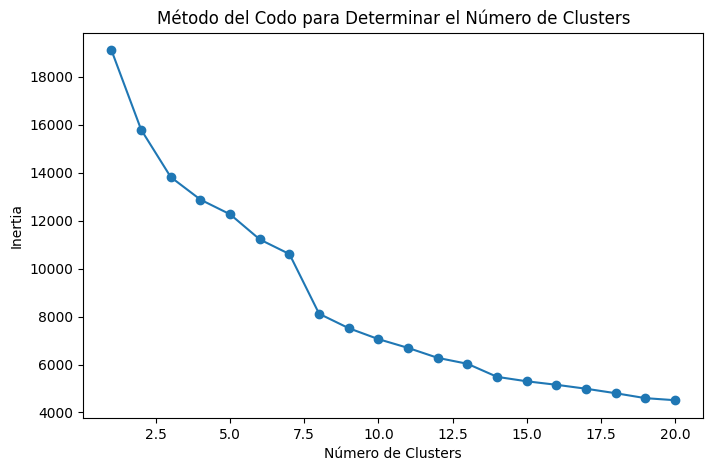

In [78]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

range_n_clusters = range(1, 21)

inertia = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(A)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método del Codo para Determinar el Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()


In [79]:
optimal_k = 7

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(A)

df_features['cluster_IT5'] = cluster_labels

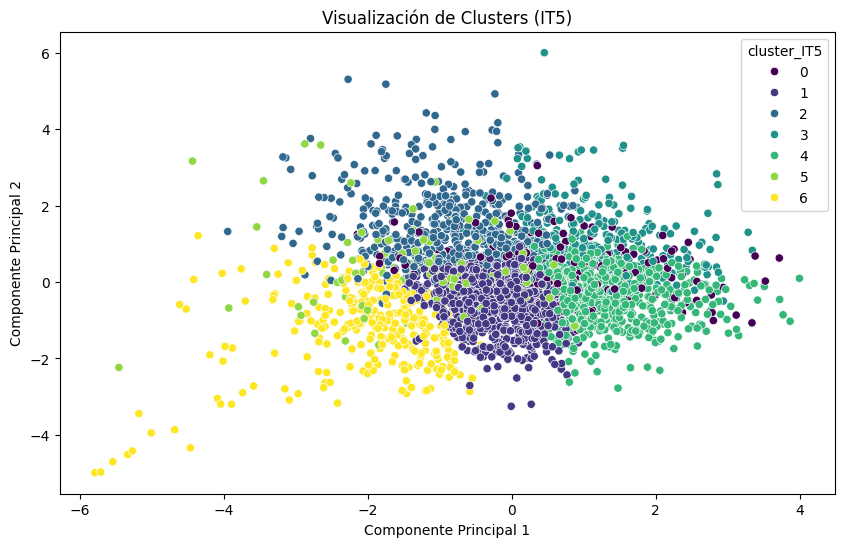

In [80]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=A.iloc[:, 0], y=A.iloc[:, 1], hue=df_features['cluster_IT5'], palette='viridis')
plt.title('Visualización de Clusters (IT5)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

## IT5. Silhouette Coefficient

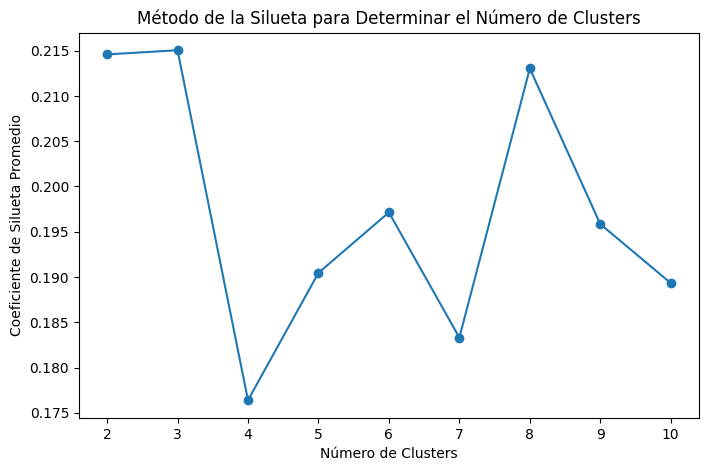

In [81]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

range_n_clusters = range(2, 11)

silhouette_avg = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(A)
    silhouette_avg.append(silhouette_score(A, cluster_labels))

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Método de la Silueta para Determinar el Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.show()


In [82]:
df_features

,total_sales,ratio_ventas_Boston,ratio_ventas_Nueva_York,ratio_ventas_Filadelfia,ventas_T1_ratio,ventas_T2_ratio,ventas_T3_ratio,ventas_T4_ratio,avg_price,average_growth,cluster_IT5
item,,,,,,,,,,,
ACCESORIES_1_001,3421,0.260450,0.617071,0.122479,0.194388,0.192341,0.277989,0.335282,11.500474,36.441469,3
ACCESORIES_1_002,4727,0.180664,0.321980,0.497356,0.170933,0.193780,0.273535,0.361752,5.275658,8.896934,6
ACCESORIES_1_003,1110,0.285586,0.481081,0.233333,0.196396,0.252252,0.286486,0.264865,3.947985,32.528409,1
ACCESORIES_1_004,37022,0.253930,0.575658,0.170412,0.244152,0.261898,0.241424,0.252526,5.962309,6.231402,4
ACCESORIES_1_005,13315,0.293428,0.501089,0.205483,0.189110,0.204807,0.278783,0.327300,3.841816,5.047894,4
...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,14119,0.150790,0.661237,0.187974,0.246476,0.202847,0.271903,0.278773,3.346143,22.277238,4
SUPERMARKET_3_824,8179,0.212495,0.534540,0.252965,0.232425,0.312752,0.264213,0.190610,3.032904,-25.916844,4
SUPERMARKET_3_825,12346,0.279362,0.462336,0.258302,0.266483,0.239349,0.284789,0.209380,4.946857,9.832011,1


## IT5. Fichas

In [83]:
features_df = df_features[[
    'total_sales',
    'ratio_ventas_Boston',
    'ratio_ventas_Nueva_York',
    'ratio_ventas_Filadelfia',
    #'ventas_T1_ratio',
    #'ventas_T2_ratio',
    #'ventas_T3_ratio',
    'ventas_T4_ratio',
    #'std_price_T1',
    #'std_price_T2',
    #'std_price_T3',
    #'std_price_T4',
    'avg_price',
    #'price_sensitivity',
    #'event_impact_ratio_T1',
    #'event_impact_ratio_T2',
    #'event_impact_ratio_T3',
    #'event_impact_ratio_T4',
    #'growth_2012',
    #'growth_2013',
    #'growth_2014',
    #'growth_2015',
    'average_growth',
    'cluster_IT5'
    ]].groupby("cluster_IT5").describe().T

features_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [85]:
df_features[df_features['cluster_5']==3]

,total_sales,ratio_ventas_Boston,ratio_ventas_Nueva_York,ratio_ventas_Filadelfia,ventas_T1_ratio,ventas_T2_ratio,ventas_T3_ratio,ventas_T4_ratio,sales_volatility,avg_price,...,growth_2014,growth_2015,average_growth,event_impact_ratio_T1,event_impact_ratio_T2,event_impact_ratio_T3,event_impact_ratio_T4,cluster_4,cluster_5,cluster_6
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,3421,0.260450,0.617071,0.122479,0.194388,0.192341,0.277989,0.335282,2.059285,11.500474,...,118.493151,27.272727,36.441469,0.114286,0.167173,0.000000,0.068003,3,3,5
ACCESORIES_1_003,1110,0.285586,0.481081,0.233333,0.196396,0.252252,0.286486,0.264865,1.083329,3.947985,...,0.000000,130.113636,32.528409,0.091743,0.135714,0.000000,0.068027,3,3,5
ACCESORIES_1_005,13315,0.293428,0.501089,0.205483,0.189110,0.204807,0.278783,0.327300,5.091120,3.841816,...,-11.893584,40.719361,5.047894,0.163225,0.057939,0.046606,0.068380,3,3,3
ACCESORIES_1_007,2661,0.219842,0.437054,0.343104,0.218339,0.194664,0.272830,0.314168,1.361170,10.501809,...,27.442529,-1.578354,54.883765,0.142857,0.104247,0.023416,0.064593,3,3,3
ACCESORIES_1_026,2960,0.203716,0.361824,0.434459,0.204054,0.216216,0.270270,0.309459,1.778961,23.878824,...,127.238806,2.545156,32.445990,0.105960,0.131250,0.011250,0.074236,3,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_795,23913,0.209342,0.467235,0.323422,0.195584,0.213189,0.271902,0.319324,12.283263,3.403574,...,401.247401,32.839071,108.521618,0.134702,0.154178,0.000000,0.073468,3,3,5
SUPERMARKET_3_796,1625,0.237538,0.296000,0.466462,0.164308,0.000000,0.259077,0.576615,2.737383,3.282176,...,0.000000,373.289902,93.322476,0.074906,0.000000,0.000000,0.085379,3,3,3
SUPERMARKET_3_798,2754,0.220407,0.471678,0.307916,0.188453,0.262527,0.261075,0.287945,2.053135,2.380000,...,41.607898,10.856574,13.116118,0.146435,0.089903,0.015299,0.085750,3,3,5


In [86]:
df_filtered[df_filtered['item']=='SUPERMARKET_3_064']

,id,item,category,department,store,store_code,region,año,semana,trimestre,event,ventas,yearweek,sell_price,date,month,quarter,is_event
2288,SUPERMARKET_3_064_BOS_1,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,South_End,BOS_1,Boston,2011,4,1,Sin_Evento,0,201104,1.20,2011-01-30,1,2011Q1,0
5337,SUPERMARKET_3_064_BOS_2,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,Roxbury,BOS_2,Boston,2011,4,1,Sin_Evento,0,201104,1.20,2011-01-30,1,2011Q1,0
8386,SUPERMARKET_3_064_BOS_3,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,Back_Bay,BOS_3,Boston,2011,4,1,Sin_Evento,0,201104,1.20,2011-01-30,1,2011Q1,0
11435,SUPERMARKET_3_064_NYC_1,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,Greenwich_Village,NYC_1,New York,2011,4,1,Sin_Evento,0,201104,1.78,2011-01-30,1,2011Q1,0
14484,SUPERMARKET_3_064_NYC_2,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,Harlem,NYC_2,New York,2011,4,1,Sin_Evento,0,201104,1.20,2011-01-30,1,2011Q1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8280323,SUPERMARKET_3_064_NYC_3,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,2015,51,4,Sin_Evento,11,201551,1.42,2015-12-27,12,2015Q4,0
8283372,SUPERMARKET_3_064_NYC_4,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,2015,51,4,Sin_Evento,32,201551,1.42,2015-12-27,12,2015Q4,0
8286421,SUPERMARKET_3_064_PHI_1,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,2015,51,4,Sin_Evento,20,201551,1.42,2015-12-27,12,2015Q4,0
8289470,SUPERMARKET_3_064_PHI_2,SUPERMARKET_3_064,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,2015,51,4,Sin_Evento,22,201551,1.42,2015-12-27,12,2015Q4,0


In [87]:
df_filtered[df_filtered['item'] == 'SUPERMARKET_3_064'].groupby(['item', 'año'])['ventas'].sum()

item               año 
SUPERMARKET_3_064  2011        1
                   2012     9699
                   2013    15380
                   2014    19697
                   2015    22429
Name: ventas, dtype: int64